# 1. Importing libraries and loading datasets

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import scipy.stats as st
warnings.filterwarnings(action='ignore')

We first load the dataset that contains the average rating and number of votes for each movie ID. 

In [3]:
df = pd.read_csv('/content/drive/My Drive/data.tsv',encoding='utf-8',delimiter='\t')
print (df.head())

      tconst  averageRating  numVotes
0  tt0000001            5.7      1635
1  tt0000002            6.1       198
2  tt0000003            6.5      1327
3  tt0000004            6.2       120
4  tt0000005            6.1      2107


The second dataset is the curated dataset which contains the **manually added like/dislike values** as well as the following key variables:
- isAdult
- startear
- runtimeMinutes
- genres

In [4]:
df_labeled = pd.read_csv('/content/drive/My Drive/movies_labeled.csv',encoding='utf-8')
print (df_labeled.head())

   Unnamed: 0  Unnamed: 0.1  ...  runtimeMinutes                   genres
0          37            47  ...             153      Adventure,Drama,War
1          41            51  ...              90  Action,Adventure,Sci-Fi
2          51            62  ...             126  Action,Adventure,Sci-Fi
3          89           110  ...             162     Action,Drama,Mystery
4         107           132  ...             153  Action,Adventure,Family

[5 rows x 11 columns]


# 2. Data cleaning

In [5]:
#Dropping index variables leftover from previous cleaning steps
df_labeled = df_labeled.drop(['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1'],axis=1)
df_labeled.head()

,tconst,titleType,primaryTitle,Like,isAdult,startYear,runtimeMinutes,genres
0,tt0361748,movie,Inglourious Basterds,1.0,0,2009,153,"Adventure,Drama,War"
1,tt0364970,movie,Babylon A.D.,2.0,0,2008,90,"Action,Adventure,Sci-Fi"
2,tt0371746,movie,Iron Man,1.0,0,2008,126,"Action,Adventure,Sci-Fi"
3,tt0409459,movie,Watchmen,2.0,0,2009,162,"Action,Drama,Mystery"
4,tt0417741,movie,Harry Potter and the Half-Blood Prince,1.0,0,2009,153,"Action,Adventure,Family"


Below, we merge the two datasets on the *tconst* variable so that we have variables relating to each movie from each dataset.

In [6]:
df_combined = df.merge(df_labeled,on='tconst',how='inner')
df_combined.head()

,tconst,averageRating,numVotes,titleType,primaryTitle,Like,isAdult,startYear,runtimeMinutes,genres
0,tt0361748,8.3,1222518,movie,Inglourious Basterds,1.0,0,2009,153,"Adventure,Drama,War"
1,tt0364970,5.6,92368,movie,Babylon A.D.,2.0,0,2008,90,"Action,Adventure,Sci-Fi"
2,tt0371746,7.9,917136,movie,Iron Man,1.0,0,2008,126,"Action,Adventure,Sci-Fi"
3,tt0376136,6.2,97574,movie,The Rum Diary,2.0,0,2011,119,"Comedy,Drama"
4,tt0409459,7.6,488627,movie,Watchmen,2.0,0,2009,162,"Action,Drama,Mystery"


In [ ]:
df_combined.shape

(130, 10)

# 3. EDA

Text(0, 0.5, 'Frequency')

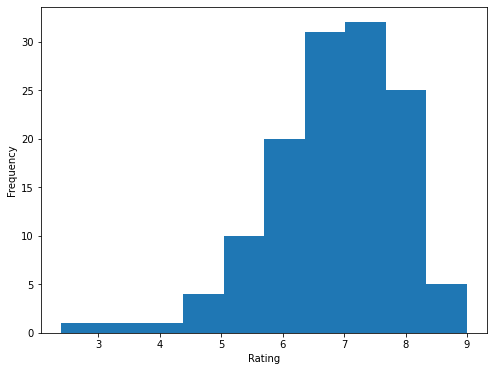

In [7]:
plt.figure(figsize=(8,6))
plt.hist(df_combined['averageRating'])
plt.xlabel("Rating")
plt.ylabel("Frequency")

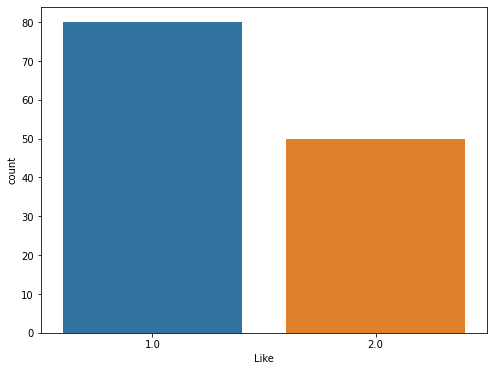

In [8]:
plt.figure(figsize=(8,6))
sns.countplot(data=df_combined,x='Like')

In [9]:
df_labeled['Like'].value_counts()

1.0    80
2.0    50
Name: Like, dtype: int64

From the distribution of liked vs disliked movies above, it doesn't appear that any of the classes are imbalanced. Although, the proportion of disliked movies is distinctly lower. 

# 4. Pre-processing and feature engineering

Next, a new variable called 'high_rating' is created of boolean type which indicates if a rating for a movie is above 7.5 or not. This is a critical step in the feature engineering process. 

In [10]:
df_combined['high_rating'] = (df_combined['averageRating']>7.5).map(int)
df_combined['high_rating'].head(10)

0    1
1    0
2    1
3    0
4    1
5    1
6    0
7    0
8    0
9    0
Name: high_rating, dtype: int64

Below, we replace the '0' boolean values for 'high_rating' to a '2' as that is what we used for manually labelling the disliked movies. The comparison across the two variables will be easier due to this. 

In [11]:
df_combined['high_rating'] = df_combined['high_rating'].replace(0,2)
df_combined['high_rating'].head()

0    1
1    2
2    1
3    2
4    1
Name: high_rating, dtype: int64

Next, we compare the manual ratings to the actual ratings based on the 7.5 threshold. This could be considered a baseline model and a smaller-scale rule-based model.

In [12]:
correct_predictions = (df_combined['high_rating']==df_combined['Like']).map(int).sum()

In [13]:
df_combined[['primaryTitle','Like','high_rating','averageRating']].head(20)

,primaryTitle,Like,high_rating,averageRating
0,Inglourious Basterds,1.0,1,8.3
1,Babylon A.D.,2.0,2,5.6
2,Iron Man,1.0,1,7.9
3,The Rum Diary,2.0,2,6.2
4,Watchmen,2.0,1,7.6
5,Harry Potter and the Half-Blood Prince,1.0,1,7.6
6,Get Smart,1.0,2,6.5
7,Superhero Movie,2.0,2,4.5
8,Role Models,2.0,2,6.8
9,Daybreakers,2.0,2,6.4


In [14]:
accuracy = correct_predictions/df_combined.shape[0]
print ("Baseline model accuracy",accuracy)

Baseline model accuracy 0.5923076923076923


Our baseline rule-based model produced an accuracy of 59% which is not that great. We now try to further optimize this rather simple model.

# 5. Model Optimization

In [15]:
#Function to calculate model accuracy for the given threshold
def rating_threshold(df,threshold):
  df['high_rating'] = (df['averageRating']>threshold).map(int)
  df['high_rating'] = df['high_rating'].replace(0,2)
  correct_predictions = (df['high_rating']==df['Like']).map(int).sum()
  accuracy = correct_predictions/df.shape[0]
  return accuracy

In [16]:
#Collecting all the accuracy values for the various thresholds into a list
acc = []
for i in np.linspace(4,7.5,36):
  acc.append(rating_threshold(df_combined[['primaryTitle','Like','high_rating','averageRating']],i))

Text(0, 0.5, 'Accuracy')

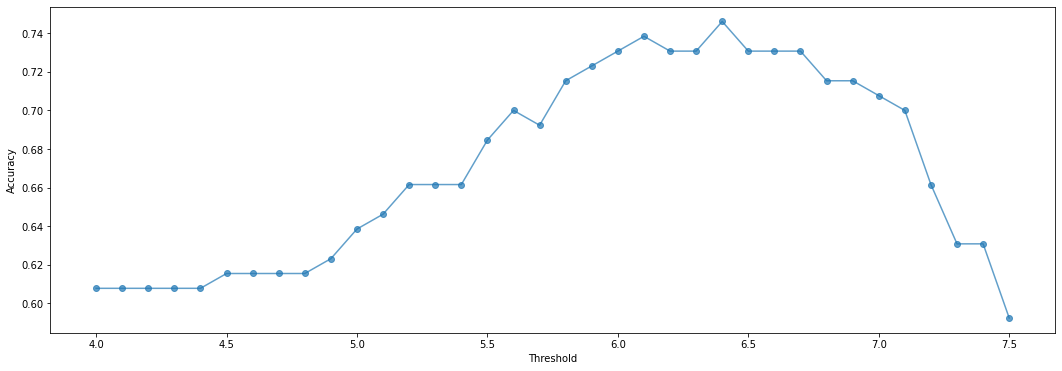

In [17]:
#Plotting the accuracy values across thresholds
plt.figure(figsize=(18,6))
plt.plot(np.linspace(4,7.5,36),acc,marker='o',alpha=0.7)
plt.xlabel('Threshold')
plt.ylabel('Accuracy')

From the above plot, we can see that as the threshold for deciding whether a movie is good or not is increased, the accuracy of the model goes down which is expected. 

Since we are trying to predict what movies I'll like, we need to find the optimal threshold to create a variable that more accuractely predicts the likes and dislikes. 

To truly understand the chart above, we need to think about **overfitting** and **underfitting**. 

If we set our threshold to 4, essentially all movies are going to be labeled as 'like', in which case we are most likely to get an accuracy which is essentially equal to the proportion of movies that I liked. That fraction is 80/130 which is 0.615. And that is exactly what we see in the plot. 

As the threshold increases, we start more accurately predicting the disliked movies so our overall accuracy increases. This basically means that our true negatives increase without reducing the true positives. 

We reach the **best accuracy score of 0.75 at a threshold of 6.4** giving us the best tradeoff between bias and variance. If we further increase the threshold after that, we would still accurately predict the disliked movies but we would wrongly predict the liked movies, so our true positives would decrease and false negatives would increase. 

For practical purposes, we **choose a threshold of 7.1** as that is generally a better value than 6.4 to separate good from bad movies while keeping the accuracy at a respectable 70%. 

# 6. More EDA

### 6.1 Rating

In [18]:
#Creating a variable that sets a boolean for rating above 7.1
df_combined['high_rating_7p1'] = (df_combined['averageRating']>7.1).map(int)
df_combined['high_rating_7p1'] = df_combined['high_rating_7p1'].replace(0,2)
df_combined.head()

,tconst,averageRating,numVotes,titleType,primaryTitle,Like,isAdult,startYear,runtimeMinutes,genres,high_rating,high_rating_7p1
0,tt0361748,8.3,1222518,movie,Inglourious Basterds,1.0,0,2009,153,"Adventure,Drama,War",1,1
1,tt0364970,5.6,92368,movie,Babylon A.D.,2.0,0,2008,90,"Action,Adventure,Sci-Fi",2,2
2,tt0371746,7.9,917136,movie,Iron Man,1.0,0,2008,126,"Action,Adventure,Sci-Fi",1,1
3,tt0376136,6.2,97574,movie,The Rum Diary,2.0,0,2011,119,"Comedy,Drama",2,2
4,tt0409459,7.6,488627,movie,Watchmen,2.0,0,2009,162,"Action,Drama,Mystery",1,1


Text(0.5, 1.0, 'True and false predictions across actual predictions for rating threshold of 7.1')

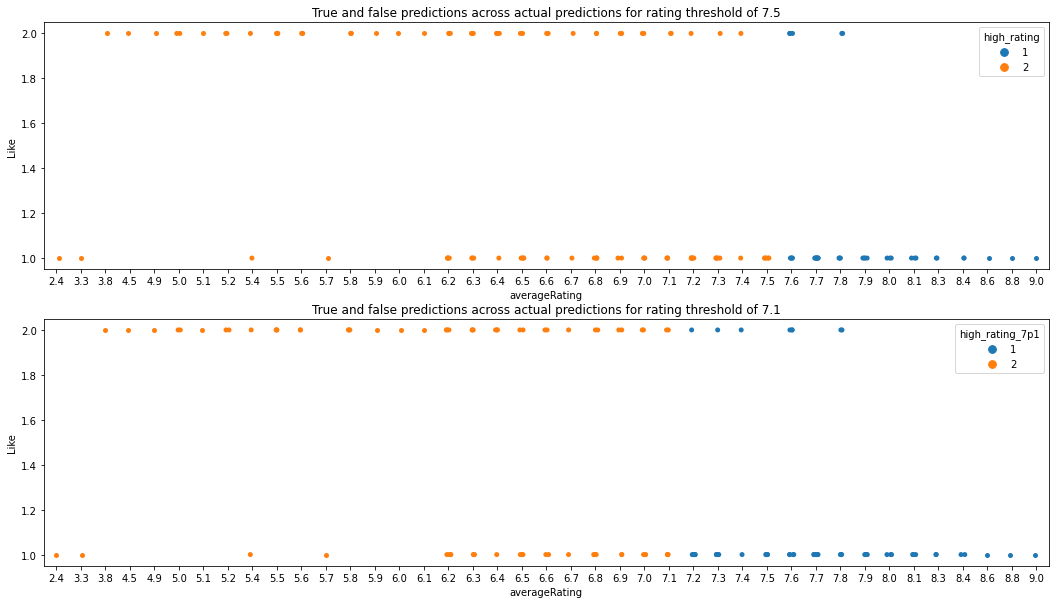

In [19]:
#Visualizing predictions for thresholds of 7.5 and 7.1
plt.figure(figsize=(18,10))
plt.subplot(2,1,1)
sns.stripplot(data=df_combined,x='averageRating',y='Like',hue='high_rating')
plt.title("True and false predictions across actual predictions for rating threshold of 7.5")
plt.subplot(2,1,2)
sns.stripplot(data=df_combined,x='averageRating',y='Like',hue='high_rating_7p1')
plt.title("True and false predictions across actual predictions for rating threshold of 7.1")

The above plot explains the difference between the 7.5 and 7.1 a little further. The x-axis is the actual like and dislike values whereas the legend shows the predicted values. 
- **Threshold of 7.5**: Predicting disliked movies better but not predicting liked movies that well. More true negatives but also more false negatives. 
- **Threshold of 7.1**: Predicting liked movies better but compromising on disliked movies. More true positives but also more false positives. 

### 6.2 Run time

In [ ]:
df_combined.head()

,tconst,averageRating,numVotes,titleType,primaryTitle,Like,isAdult,startYear,runtimeMinutes,genres,high_rating,high_rating_7p1
0,tt0361748,8.3,1222518,movie,Inglourious Basterds,1.0,0,2009,153,"Adventure,Drama,War",1,1
1,tt0364970,5.6,92368,movie,Babylon A.D.,2.0,0,2008,90,"Action,Adventure,Sci-Fi",2,2
2,tt0371746,7.9,917136,movie,Iron Man,1.0,0,2008,126,"Action,Adventure,Sci-Fi",1,1
3,tt0376136,6.2,97574,movie,The Rum Diary,2.0,0,2011,119,"Comedy,Drama",2,2
4,tt0409459,7.6,488627,movie,Watchmen,2.0,0,2009,162,"Action,Drama,Mystery",1,1


Text(0.5, 1.0, 'Plot of rating vs runtime distinguishing movies rated higher than 7.1')

<Figure size 1152x432 with 0 Axes>

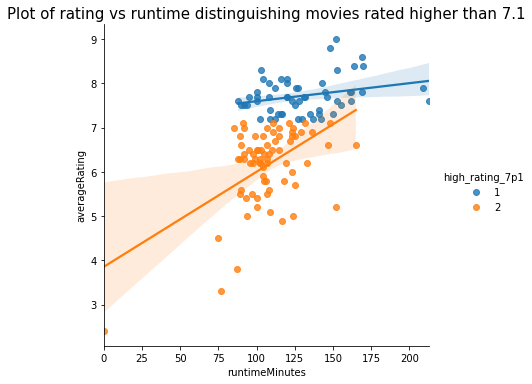

In [23]:
plt.figure(figsize=(16,6))
df_combined['runtimeMinutes'] = df_combined['runtimeMinutes'].replace('\\N','0')
df_combined['runtimeMinutes'] = df_combined['runtimeMinutes'].map(int)
sns.lmplot(data=df_combined,x='runtimeMinutes',y='averageRating',hue='high_rating_7p1',fit_reg=True)
plt.title("Plot of rating vs runtime distinguishing movies rated higher than 7.1",size=15)

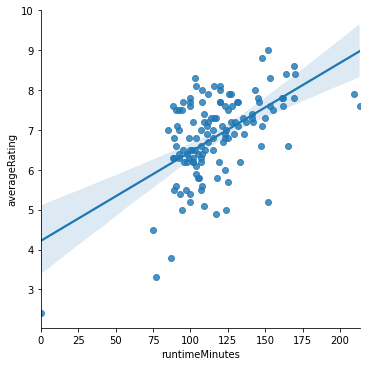

In [24]:
sns.lmplot(data=df_combined,x='runtimeMinutes',y='averageRating',fit_reg=True)

In [25]:
np.corrcoef(df_combined['averageRating'],df_combined['runtimeMinutes'])

array([[1.        , 0.56400846],
       [0.56400846, 1.        ]])

Above, we see that there is a weak relation between runtime and average rating. 

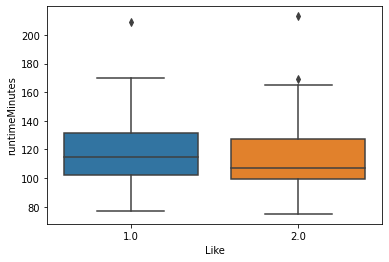

In [ ]:
sns.boxplot(data=df_combined,y='runtimeMinutes',x='Like')

In [ ]:
np.corrcoef(df_combined['Like'],df_combined['runtimeMinutes'])

array([[ 1.        , -0.06462848],
       [-0.06462848,  1.        ]])

In [32]:
df_combined[['runtimeMinutes','Like']].groupby('Like').agg(['mean','median'])

runtimeMinutes       
               mean median
Like                      
1.0      119.303797    115
2.0      116.020000    107

To see whether runtime can explain the difference between liked and disliked movies, we created a boxplot above. 

The boxplot shows a slightly higher median for liked movies. To be exact, the median for liked and disliked movies are 115 and 107 respectively. We could check whether this difference is statistically significant but that will be covered in a later revision of the project. For now, we will include the variable in our base model.

### 6.3 PG rating

In [ ]:
df_combined['isAdult'].value_counts()

0    129
Name: isAdult, dtype: int64

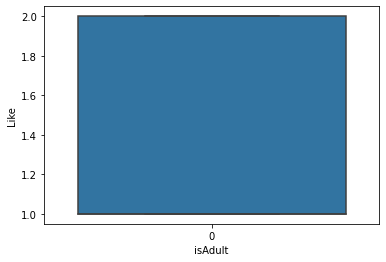

In [ ]:
sns.boxplot(data=df_combined,x='isAdult',y='Like')

There appears to be only one *PG rating* - 0. Hence this variable is not informative at all for our purposes. 

### 6.4 Number of Votes

In [ ]:
df_combined[['numVotes','Like']].groupby(['Like']).agg(['count','sum','median','mean','std'])

numVotes                                                
        count       sum  median           mean            std
Like                                                         
1.0        79  35879912  328992  454176.101266  428823.806155
2.0        50  10476664  129761  209533.280000  186067.351210

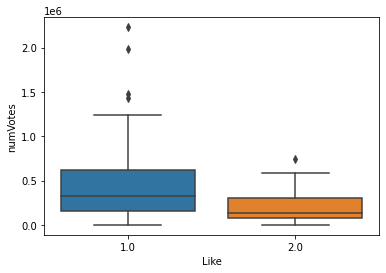

In [ ]:
sns.boxplot(data=df_combined,y='numVotes',x='Like')

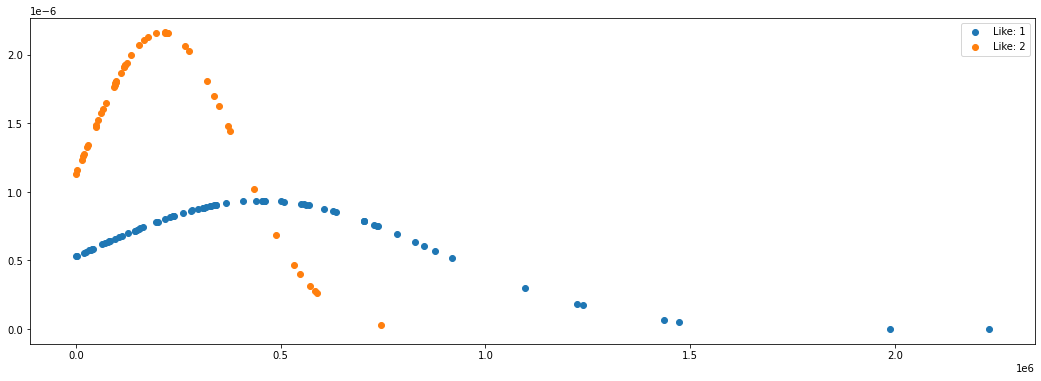

In [ ]:
df_like_1 = df_combined[df_combined['Like']==1.0]
df_like_2 = df_combined[df_combined['Like']==2.0]
df_like_1_votes_pdf = st.norm.pdf(df_like_1['numVotes'],np.mean(df_like_1['numVotes']),np.std(df_like_1['numVotes']))
df_like_2_votes_pdf = st.norm.pdf(df_like_2['numVotes'],np.mean(df_like_2['numVotes']),np.std(df_like_2['numVotes']))

plt.figure(figsize=(18,6))
plt.scatter(df_like_1['numVotes'],df_like_1_votes_pdf,label='Like: 1')
plt.scatter(df_like_2['numVotes'],df_like_2_votes_pdf,label='Like: 2')
plt.legend()

From the boxplot and probability density curves, it is clear that there is a slightly more clear correlation between the number of votes and the liked movies. 

Below, we explore the number of votes and average rating variables to see if there is a systematic correlation. 

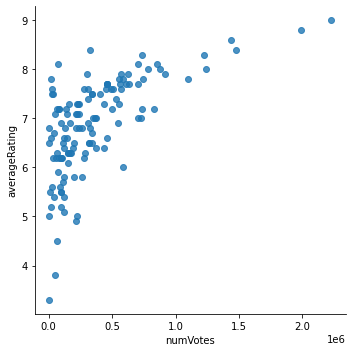

In [ ]:
sns.lmplot(data=df_combined,x='numVotes',y='averageRating',fit_reg=False)

In [ ]:
np.corrcoef(df_combined['numVotes'],df_combined['averageRating'])

array([[1.        , 0.63229244],
       [0.63229244, 1.        ]])

There appears to be a medium correlation between number of votes and average rating. It is possible that people are more exited to rate movies if they really liked it so that could lead to a bias when comparing votes and ratings. 

For now, we will also include this variable in our base model.

In [ ]:
df_combined.head()

,tconst,averageRating,numVotes,titleType,primaryTitle,Like,isAdult,startYear,runtimeMinutes,genres,high_rating,high_rating_7p1
0,tt0361748,8.3,1222518,movie,Inglourious Basterds,1.0,0,2009,153,"Adventure,Drama,War",1,1
1,tt0364970,5.6,92368,movie,Babylon A.D.,2.0,0,2008,90,"Action,Adventure,Sci-Fi",2,2
2,tt0371746,7.9,917136,movie,Iron Man,1.0,0,2008,126,"Action,Adventure,Sci-Fi",1,1
3,tt0376136,6.2,97574,movie,The Rum Diary,2.0,0,2011,119,"Comedy,Drama",2,2
4,tt0409459,7.6,488627,movie,Watchmen,2.0,0,2009,162,"Action,Drama,Mystery",1,1


### 6.5 High Rating

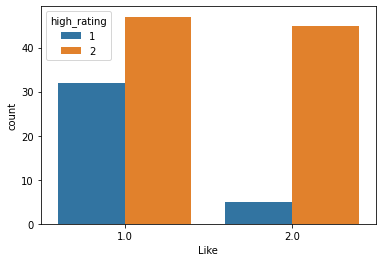

In [ ]:
sns.countplot(data=df_combined,x='Like',hue='high_rating')

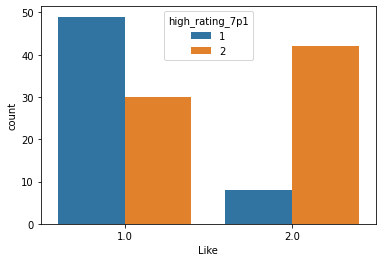

In [ ]:
sns.countplot(data=df_combined,x='Like',hue='high_rating_7p1')

In [33]:
df_combined['high_rating_6p4'] = (df_combined['averageRating']>6.4).map(int)
df_combined.head()


,tconst,averageRating,numVotes,titleType,primaryTitle,Like,isAdult,startYear,runtimeMinutes,genres,high_rating,high_rating_7p1,high_rating_6p4
0,tt0361748,8.3,1222518,movie,Inglourious Basterds,1.0,0,2009,153,"Adventure,Drama,War",1,1,1
1,tt0364970,5.6,92368,movie,Babylon A.D.,2.0,0,2008,90,"Action,Adventure,Sci-Fi",2,2,0
2,tt0371746,7.9,917136,movie,Iron Man,1.0,0,2008,126,"Action,Adventure,Sci-Fi",1,1,1
3,tt0376136,6.2,97574,movie,The Rum Diary,2.0,0,2011,119,"Comedy,Drama",2,2,0
4,tt0409459,7.6,488627,movie,Watchmen,2.0,0,2009,162,"Action,Drama,Mystery",1,1,1


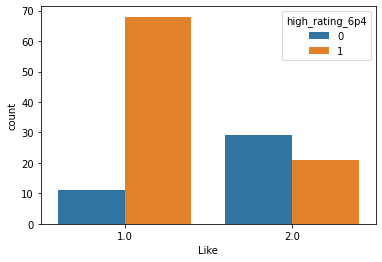

In [34]:
sns.countplot(data=df_combined,x='Like',hue='high_rating_6p4')

Above, we have created 3 plots with each having a different rating threshold:
- **7.5**: Base threshold
- **7.1**: Practical threshold
- **6.4**: Best threshold based on data

The 7.5 threshold is good at predicting liked movies but poor at predicting disliked movies. The 7.1 rating does equally well with liked movies and slightly improves with disliked movies. The 6.4 threshold does really well with disliked movies but does poorly with liked movies.

Based on these results, we choose 7.1 as the best threshold to use for our model. 

# 7. Prediction Using ML - Decision Trees

We use decision trees for this modeling process since it's interpretable, fast and simple for the features that we are using. 

Also, note that we have only 2 variables:
- *numVotes*
- *high_rating_7p1*

We did not use runtime as it was not a great distinguisher of liked and disliked movies.

In [42]:
x = df_combined[['numVotes','high_rating_7p1']]
y = df_combined['Like']
print (x.shape)
print (y.shape)

(129, 2)
(129,)


In [43]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

### 7.1 Pre-processing

Below, we just transform the high_rating_7p1 variable into integer values and split the data into training and test sets.

In [44]:
le = LabelEncoder()
x['high_rating_7p1'] = le.fit_transform(x['high_rating_7p1'])

In [45]:
x_train,x_test,y_train,y_test = train_test_split(x,y,train_size=0.7,random_state=0)
print (x_train.shape)
print (x_test.shape)
print (y_train.shape)
print (y_test.shape)

(90, 2)
(39, 2)
(90,)
(39,)


### 7.2 Baseline decision tree model

In [46]:
dt = DecisionTreeClassifier(random_state=0)
model = dt.fit(x_train,y_train)
prediction = model.predict(x_test)

In [47]:
accuracy_score(y_test,prediction)

0.6153846153846154

In [48]:
roc_auc_score(y_test,prediction)

0.576923076923077

The baseline decision trees model provides an accuracy score of 0.61 and a ROC AUC score of 0.57 which are not the best. 

In [ ]:
model

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

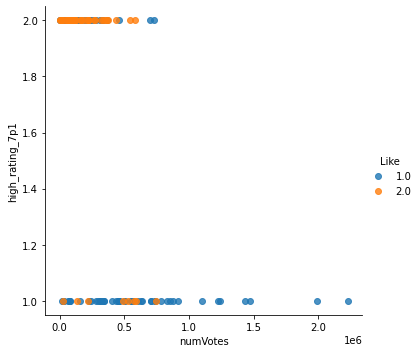

In [49]:
sns.lmplot(data=df_combined,x='numVotes',y='high_rating_7p1',hue='Like',fit_reg=False)

In [50]:
df_combined[['Like','high_rating_7p1','numVotes']].groupby(['Like','high_rating_7p1']).count()

numVotes
Like high_rating_7p1          
1.0  1                      49
     2                      30
2.0  1                       8
     2                      42

We diagnose the model a little and see that it predicts the liked movies really well, as we expected but does not model the disliked movies well. 

Maybe that says a little about my movie choices. In fact, what this says is that I tend to categorize the good movies correctly but I also sometimes categorize bad movies as good movies. 

### 7.3 Model with Average Rating

In [51]:
def dt_model(features):
  x = features
  y = df_combined['Like']
  print (x.shape)
  print (y.shape)
  x_train,x_test,y_train,y_test = train_test_split(x,y,train_size=0.7,random_state=0)
  print (x_train.shape)
  print (x_test.shape)
  print (y_train.shape)
  print (y_test.shape)
  dt = DecisionTreeClassifier()
  model = dt.fit(x_train,y_train)
  prediction = model.predict(x_test)
  print ("Accuracy: ",accuracy_score(y_test,prediction))
  print ("ROC AUC: ",roc_auc_score(y_test,prediction))

In [52]:
dt_model(df_combined[['numVotes','averageRating']])

(129, 2)
(129,)
(90, 2)
(39, 2)
(90,)
(39,)
Accuracy:  0.5641025641025641
ROC AUC:  0.5384615384615385


Adding the original average rating variable instead of the high_rating_7p1 variable yields a lower accuracy and AUC score. This is expected since the latter variable is a feature engineered (categorized) version of the former for a more optimized prediction. 

### 7.4 Optimization - Grid Search

Parameter tuning for Decision Trees - https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680

In [53]:
from sklearn.model_selection import GridSearchCV

In [54]:
param = {'max_depth':[1,2,4,5,6,7,8,9,10],'min_samples_split':[1,2,3,4,5,8,10,20]}
#scoring = {'AUC': 'roc_auc', 'Accuracy': 'accuracy'}
clf = GridSearchCV(dt,param,scoring='roc_auc',cv=5)
clf.fit(x_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=0, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [1, 2, 4, 5, 6, 7, 8, 9, 10],
                         'min_samples_split': [1, 2, 3, 4, 

In [55]:
print ("Best model: ",clf.best_estimator_)
print ("Best model parameters: ",clf.best_params_)
print ("Best ROC AUC score: ",clf.best_score_)
print ("Best features: ",model.feature_importances_)

Best model:  DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=1, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')
Best model parameters:  {'max_depth': 1, 'min_samples_split': 2}
Best ROC AUC score:  0.7621428571428571
Best features:  [0.72950025 0.27049975]


In [ ]:
clf.cv_results_

{'mean_fit_time': array([0.00286036, 0.00192246, 0.00189257, 0.00191283, 0.00193238,
        0.00191631, 0.00188551, 0.00209436, 0.0018681 , 0.00215297,
        0.00211701, 0.00334883, 0.00203137, 0.00198827, 0.00201058,
        0.00194116, 0.0018456 , 0.00192008, 0.00204048, 0.00195475,
        0.00188951, 0.00189309, 0.00226722, 0.00202956, 0.00209522,
        0.00200744, 0.00193191, 0.00204997, 0.0019547 , 0.00203066,
        0.00193338, 0.00191092, 0.00180025, 0.00196466, 0.00277805,
        0.00223069, 0.00225964, 0.00205274, 0.00194502, 0.00196247,
        0.00190258, 0.00210638, 0.00199604, 0.00191803, 0.0018908 ,
        0.00188656, 0.00193377, 0.0019206 , 0.00176129, 0.00192618,
        0.00194044, 0.00196996, 0.00217514, 0.00196342, 0.00195003,
        0.00192361, 0.00177469, 0.00217562, 0.00205112, 0.00197411,
        0.00193539, 0.00256505, 0.00196261, 0.00195694, 0.00182104,
        0.00196342, 0.00195961, 0.00196285, 0.00195513, 0.00209017,
        0.00195246, 0.00192442]

### 7.5 Adding optimized parameters back to Decision Tree model

In [56]:
'''
x = df_combined[['numVotes','']]
y = df_combined['Like']
print (x.shape)
print (y.shape)
x_train,x_test,y_train,y_test = train_test_split(x,y,train_size=0.7,random_state=0)
print (x_train.shape)
print (x_test.shape)
print (y_train.shape)
print (y_test.shape)
'''
dt = DecisionTreeClassifier(max_depth=1,min_samples_split=2,random_state=0)
model = dt.fit(x_train,y_train)
prediction = model.predict(x_test)
print ("Accuracy: ",accuracy_score(y_test,prediction))
print ("ROC AUC: ",roc_auc_score(y_test,prediction))

Accuracy:  0.6153846153846154
ROC AUC:  0.6538461538461537


We see an improvement in ROC AUC from 0.57 to 0.65 but the accuracy remains the same from the baseline model. This is possibly due to us optimizing the model with respect to AUC. 

### 7.6 Visualizing the final Decision Tree model

"Visualize a Decision Tree in 4 Ways with Scikit-Learn and Python" - 
https://mljar.com/blog/visualize-decision-tree/

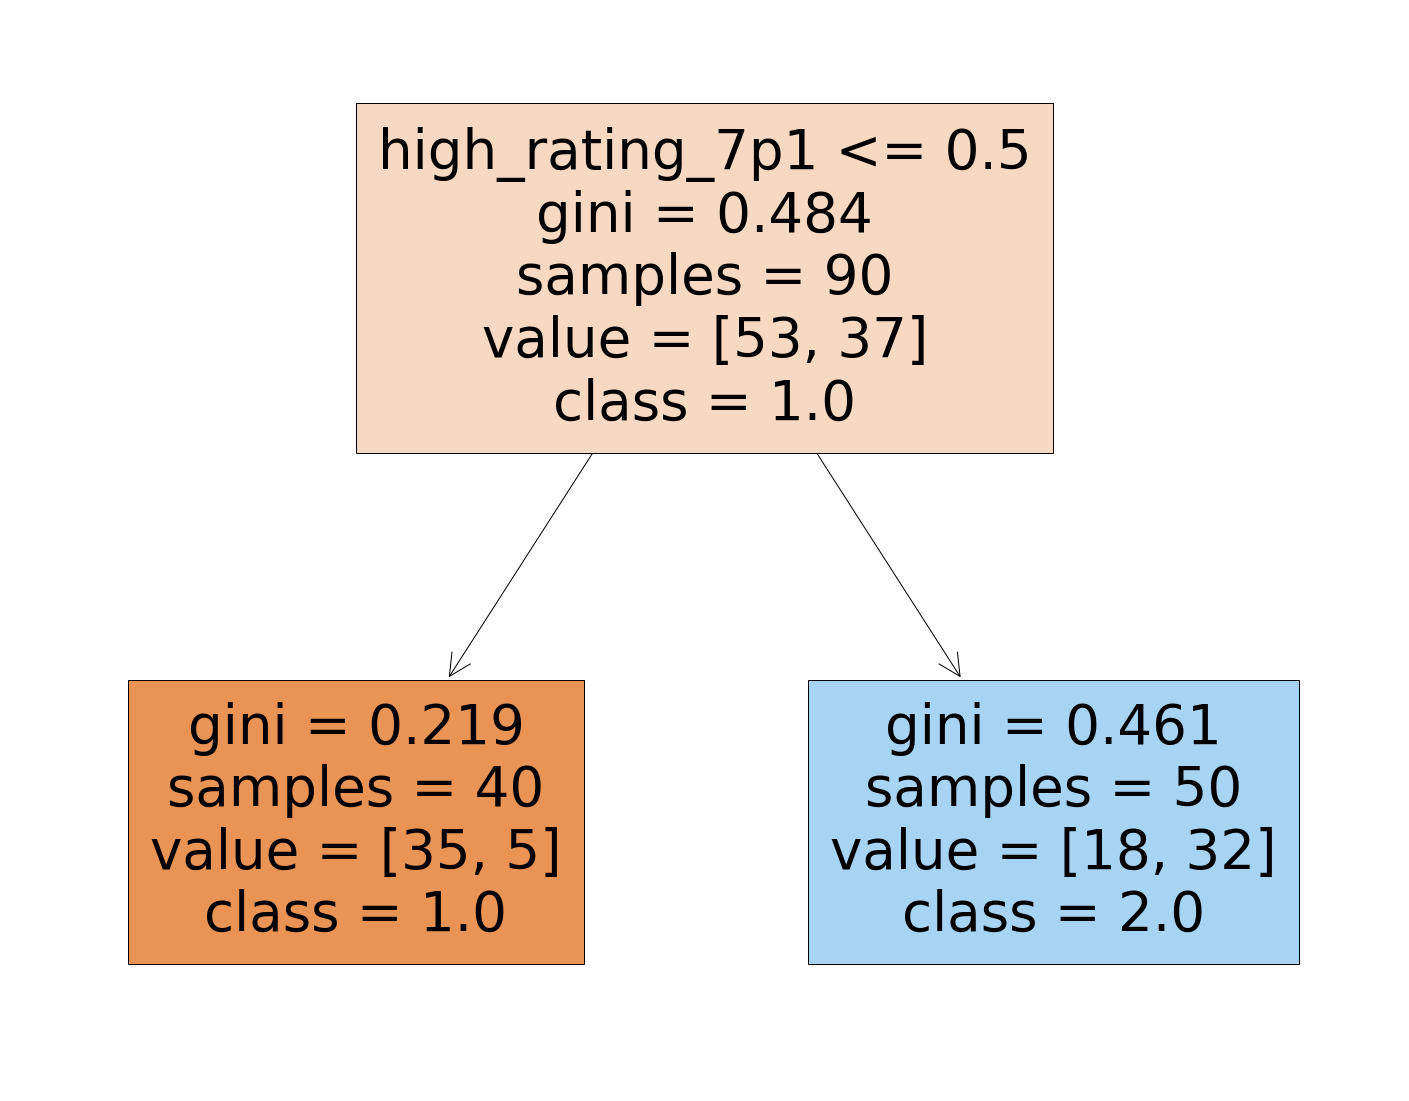

In [57]:
from sklearn import tree

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(model, 
                   feature_names=list(x.columns),  
                   class_names=pd.Series(map(str,y)).unique(),
                   filled=True)

### 7.7 Diagnosing the final model

In [59]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, prediction).ravel()

In [60]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

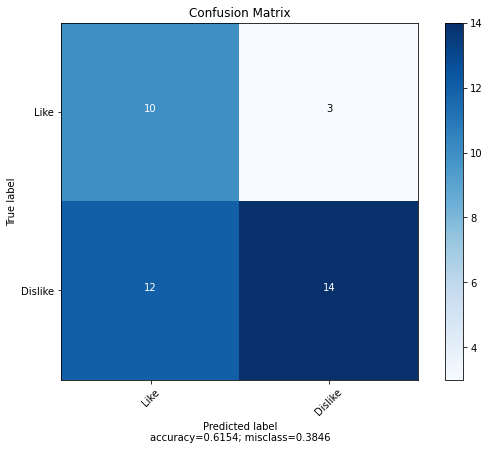

In [61]:
plot_confusion_matrix(cm= np.array([[ tp,  fn],
                                    [  fp, tn]]), 
                      normalize    = False,
                      target_names = ['Like', 'Dislike'],
                      title        = "Confusion Matrix")

The confusion matrix above confirms that we are good at predicting true positives but poor at predicting true negatives. 

For me, watching a good movie is important, so I would like to minimize false negatives. In order to do that, we would need to change the prediction threshold. However, that will decrease false negatives as well but will increase the true positives. At the same time, it will increase false positives. However, it's okay for me to miss out on good movies. What I want to avoid is watching bad movies.  

In [ ]:
df_combined['Like'].value_counts()

1.0    79
2.0    50
Name: Like, dtype: int64

### 7.8 Grid Search with *accuracy* as the scoring metric

In [64]:
param = {'max_depth':[1,2,4,5,6,7,8,9,10],'min_samples_split':[1,2,3,4,5,8,10,20]}
#scoring = {'AUC': 'roc_auc', 'Accuracy': 'accuracy'}
clf = GridSearchCV(dt,param,scoring='accuracy',cv=5)
clf.fit(x_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=1,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=0, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [1, 2, 4, 5, 6, 7, 8, 9, 10],
                         'min_samples_split': [1, 2, 3, 4, 5, 

In [65]:
print (clf.best_params_)
print (clf.best_score_)
print (clf.best_index_)

{'max_depth': 1, 'min_samples_split': 2}
0.7444444444444445
1


Interestingly, the best paramaters using *accuracy* as the scoring metric are the same as when *roc_auc* was the metric. Hence, we can stick with the previous model. 

Future modifications:
1. Look at new confusion matrix by changing threshold to increase true positives and reduce false negatives
2. Perform predictions with unseen movies
2. Add more movies to the training set and model again
3. Add more variables to the data